# Salient morphological features for predicting metallicity

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

PATH = os.path.abspath('..')

In [4]:
sz = 32
bs = 32

In [30]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv)

src = (ImageItemList.from_df(df, path=PATH, folder='train', suffix='.jpg', cols='objID')
                .random_split_by_pct(0.2, seed=1234)
                .label_from_df(cols='oh_p50',  label_cls=FloatList)
      )

data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

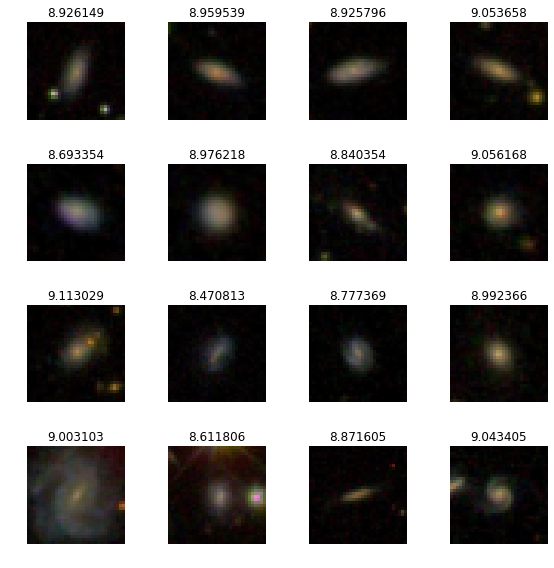

In [31]:
data.show_batch(4, figsize=(8, 8))

In [7]:
defaults.device = torch.device('cpu')

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, pretrained=False):                  # pretrained kw is hardcoded into create_cnn
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(32*32*32, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [16]:
learn = create_cnn(data, arch=SimpleCNN, pretrained=False, loss_func=root_mean_squared_error)

# Initial training

In [17]:
learn.fit_one_cycle(10, slice(1e-2, 1e-1))

epoch,train_loss,valid_loss
1,8.044052,5.534767
2,5.635538,2.238383
3,4.501487,2.301280
4,3.887902,5.123616
5,3.311468,3.730399
6,2.847287,0.673071
7,2.462462,0.352846
8,2.129157,0.565405
9,1.849612,0.300392
10,1.626877,0.318744


In [18]:
learn.fit_one_cycle(20, slice(1e-3, 1e-2))

epoch,train_loss,valid_loss
1,0.783131,0.230404
2,0.805309,0.221074
3,0.790727,0.291623
4,0.800203,0.376711
5,0.796600,0.259450
6,0.751956,0.312268
7,0.720099,0.215078
8,0.701393,0.320236
9,0.692179,0.309687
10,0.668875,0.186966


In [19]:
learn.fit_one_cycle(20, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss
1,0.512329,0.180601
2,0.521546,0.160702
3,0.524575,0.157647
4,0.516333,0.189826
5,0.520271,0.167734
6,0.519553,0.184909
7,0.506010,0.156213
8,0.499137,0.166115
9,0.501678,0.168184
10,0.510671,0.206528


In [20]:
learn.fit_one_cycle(20, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss
1,0.464318,0.161465
2,0.463328,0.160862
3,0.470751,0.160110
4,0.465778,0.157685
5,0.471049,0.158294
6,0.469624,0.163139
7,0.464884,0.160629
8,0.470000,0.155656
9,0.469597,0.154795
10,0.464966,0.156219


In [24]:
#learn.save('saliency-train-1')
learn.load('saliency-train-1');

In [25]:
tta_res = learn.TTA()

In [28]:
root_mean_squared_error(tta_res[0], tta_res[1])

tensor(0.1606)

# Testing predictions on a single image

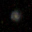

FloatItem 8.826601

In [49]:
display(learn.data.valid_ds[1][0])
display(learn.data.valid_ds[1][1])

In [50]:
learn.predict(learn.data.valid_ds[1][0])

(FloatItem [8.734838], tensor([8.7348]), tensor([8.7348]))

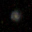

In [52]:
im = learn.data.valid_ds[1][0]


In [74]:
Image(learn.data.valid_ds[1][0] + torch.randn_like(im.data) * 1e-3)

TypeError: add(): argument 'other' (position 1) must be Tensor, not Image